In [1]:
from RADARDataCapture import FMCWRADARDataCapture
from MOCAPDataCapture import MOCAPDataCapture
from FPDataCapture import FPDataCapture
from StableRdmDataset import StableRdmDataset
import h5py
import os
import numpy as np
import pandas as pd
import imageio
import matplotlib.pyplot as plt
from datetime import datetime
import statistics
from matplotlib import animation
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
from torch import optim
from datetime import datetime
from RdmSingleVariablePrediction import RdmCNNLSTMModel


Load CSV detailing t_stable and t_break for each capture

In [2]:
event_csv_path = "/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/data/csvs/MOCAP_FP_RADAR_FU_Stable_Break_FD_TIME_FRAMES_v2.csv"

event_labels_df = pd.read_csv(event_csv_path)
print(event_labels_df.head())

    RADAR_capture  MOCAP_Start_Time  MOCAP_End_Time  RADAR_Start_Frame  \
0  01_MNTRL_RR_V1              7.33           30.57                194   
1  01_MNTRL_RR_V1              7.33           30.57                194   
2  01_MNTRL_RR_V1              7.33           30.57                194   
3  01_MNTRL_RR_V2              7.37           30.40                191   
4  01_MNTRL_RR_V2              7.37           30.40                191   

   RADAR_End_Frame  Seconds_per_Frame  tx  is_final_tx  t_foot_up  t_stable  \
0              831            0.03645   1        False      10.22     11.19   
1              831            0.03645   2        False      18.25     19.05   
2              831            0.03645   3         True      26.24     27.03   
3              822            0.03646   1        False      10.48     11.05   
4              822            0.03646   2        False      18.41     19.07   

   t_break  t_foot_down  frame_foot_up  frame_stable  frame_break  frame_end  
0

Load relavent base truth data (FP or MOCAP)

In [3]:

for index, row in event_labels_df.iterrows():
    participant = row['RADAR_capture'][:2]
    MOCAP_FP_capture_name = row['RADAR_capture'].replace('_RR_', '_MC_')
    base_file_path = f"/Volumes/FourTBLaCie/Yoga_Study_FP_1and2_MNTR/{participant}/{MOCAP_FP_capture_name}.tsv"
    force_plate_capture = FPDataCapture(base_file_path=base_file_path, is_foot_always_up=True)
    
    t_stable = row['t_stable']
    t_end = row['t_end'] if np.isnan(row['t_break']) else row['t_break'] 
    
    filtered_data = force_plate_capture.isolate_rows_by_time(t_stable, t_end)
    print(force_plate_capture.enclosing_circle_radius(filtered_data))
    break

22.656851806555302


Radius for 01_MNTRL_MC_V1, tx 1 is: 22.656851806555302
Radius for 01_MNTRL_MC_V1, tx 2 is: 21.58492080350214
Radius for 01_MNTRL_MC_V1, tx 3 is: 13.994647941690928
Radius for 01_MNTRL_MC_V2, tx 1 is: 18.429923645776658
Radius for 01_MNTRL_MC_V2, tx 2 is: 16.391415769121238
Radius for 01_MNTRL_MC_V2, tx 3 is: 21.57986117216016
Radius for 01_MNTRL_MC_V3, tx 1 is: 27.020445190493675
Radius for 01_MNTRL_MC_V3, tx 2 is: 20.93729783366728
Radius for 01_MNTRL_MC_V3, tx 3 is: 17.99415553310937
Radius for 01_MNTRR_MC_V1, tx 1 is: 18.863171982412652
Radius for 01_MNTRR_MC_V1, tx 2 is: 10.333996274966587
Radius for 01_MNTRR_MC_V1, tx 3 is: 14.10668643155401
Radius for 01_MNTRR_MC_V2, tx 1 is: 10.572482856134938
Radius for 01_MNTRR_MC_V2, tx 2 is: 20.27777167503243
Radius for 01_MNTRR_MC_V2, tx 3 is: 29.61026971321736
Radius for 01_MNTRR_MC_V3, tx 1 is: 15.396503620231604
Radius for 01_MNTRR_MC_V3, tx 2 is: 9.498483877996728
Radius for 01_MNTRR_MC_V3, tx 3 is: 16.878096424218167
Radius for 02_MNTR

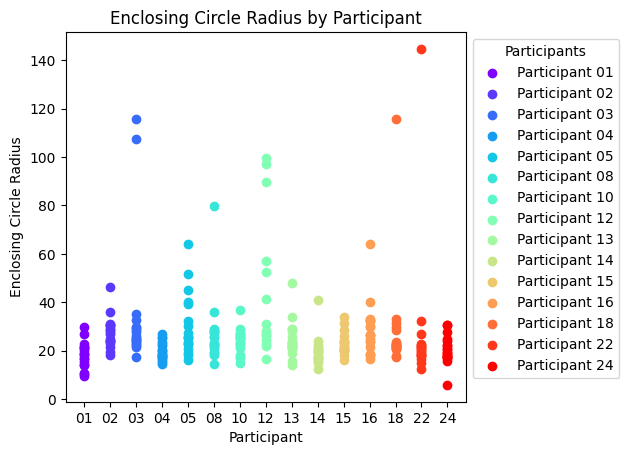

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import mplcursors

# Assuming FPDataCapture and event_labels_df are predefined and available

# Dictionary to collect results, keyed by participant with a list of radii as values
participant_results = {}

for index, row in event_labels_df.iterrows():
    participant = row['RADAR_capture'][:2]
    MOCAP_FP_capture_name = row['RADAR_capture'].replace('_RR_', '_MC_')
    base_file_path = f"/Volumes/FourTBLaCie/Yoga_Study_FP_1and2_MNTR/{participant}/{MOCAP_FP_capture_name}.tsv"
    force_plate_capture = FPDataCapture(base_file_path=base_file_path, is_foot_always_up=True)
    
    if MOCAP_FP_capture_name == '22_MNTRL_MC_V1' and  row['tx'] == "3":
        continue
    
    t_stable = row['t_stable']
    t_end = row['t_foot_down'] if np.isnan(row['t_break']) else row['t_break']
    
    filtered_data = force_plate_capture.isolate_rows_by_time(t_stable, t_end)
    
    # Ensure radius is defined outside the if-else block to avoid reference errors
    radius = None  # Default value in case of insufficient data points

    # Check if there are at least 3 unique points    
    if len(filtered_data.drop_duplicates(subset=['COP_X', 'COP_Y'])) >= 3:
        radius = force_plate_capture.enclosing_circle_radius(filtered_data)
        print(f"Radius for {MOCAP_FP_capture_name}, tx {row['tx']} is: {radius}")
        # Store the results or continue with your logic
    else:
        print(f"Not enough points to calculate radius for {MOCAP_FP_capture_name}, tx {row['tx']}")
        # Handle cases with insufficient points here
        
        # Only store the results if radius was calculated
    if radius is not None:
        if participant not in participant_results:
            participant_results[participant] = []
        # Append the tuple (radius, MOCAP_FP_capture_name, tx) to the list for this participant
        participant_results[participant].append((radius, MOCAP_FP_capture_name, row['tx']))

colors = plt.cm.rainbow(np.linspace(0, 1, len(participant_results)))
fig, ax = plt.subplots()

for (participant, results), color in zip(participant_results.items(), colors):
    radii = [result[0] for result in results]  # Extract radii
    labels = [f"{result[1]}, tx {result[2]}" for result in results]  # Prepare labels for hover
    
    # Scatter plot for each participant. Now with a label for the legend.
    scatter = ax.scatter([participant] * len(radii), radii, color=color, label=f'Participant {participant}')

    # Adding hover functionality with mplcursors
    cursor = mplcursors.cursor(scatter, hover=True)
    cursor.connect("add", lambda sel: sel.annotation.set_text(labels[sel.target.index]))

# Place the legend to the right of the plot
ax.legend(title="Participants", loc='upper left', bbox_to_anchor=(1, 1))

plt.title('Enclosing Circle Radius by Participant')
plt.xlabel('Participant')
plt.ylabel('Enclosing Circle Radius')

# Adjust figure size or layout to ensure the legend and plot do not overlap
plt.subplots_adjust(right=0.75)  # You may need to adjust this value based on your figure dimensions

plt.show()

# # Assuming you want to plot each participant's enclosing circle radius with a different color
# colors = plt.cm.rainbow(np.linspace(0, 1, len(participant_results)))

# plt.figure(figsize=(10, 6))
# for (participant, radii), color in zip(participant_results.items(), colors):
#     plt.scatter([participant] * len(radii), radii, color=color, label=f'Participant {participant}')

# plt.title('Enclosing Circle Radius by Participant')
# plt.xlabel('Participant')
# plt.ylabel('Enclosing Circle Radius')
# plt.legend()
# plt.show()


COP Velocity

velocity for 01_MNTRL_MC_V1, tx 1 is: 0.21645173899383147
velocity for 01_MNTRL_MC_V1, tx 2 is: 0.21036308521280453
velocity for 01_MNTRL_MC_V1, tx 3 is: 0.22196895690903956
velocity for 01_MNTRL_MC_V2, tx 1 is: 0.21104176675486463
velocity for 01_MNTRL_MC_V2, tx 2 is: 0.20732925501497337
velocity for 01_MNTRL_MC_V2, tx 3 is: 0.2047348509347036
velocity for 01_MNTRL_MC_V3, tx 1 is: 0.1998639933453882
velocity for 01_MNTRL_MC_V3, tx 2 is: 0.21066701984899294
velocity for 01_MNTRL_MC_V3, tx 3 is: 0.2034903306766281
velocity for 01_MNTRR_MC_V1, tx 1 is: 0.20221130063509407
velocity for 01_MNTRR_MC_V1, tx 2 is: 0.2049716267349538
velocity for 01_MNTRR_MC_V1, tx 3 is: 0.19145444187397528
velocity for 01_MNTRR_MC_V2, tx 1 is: 0.19718864242918793
velocity for 01_MNTRR_MC_V2, tx 2 is: 0.19700301456924055
velocity for 01_MNTRR_MC_V2, tx 3 is: 0.19867361286568103
velocity for 01_MNTRR_MC_V3, tx 1 is: 0.21567696232623146
velocity for 01_MNTRR_MC_V3, tx 2 is: 0.20936760338674842
velocity for 01_MN

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


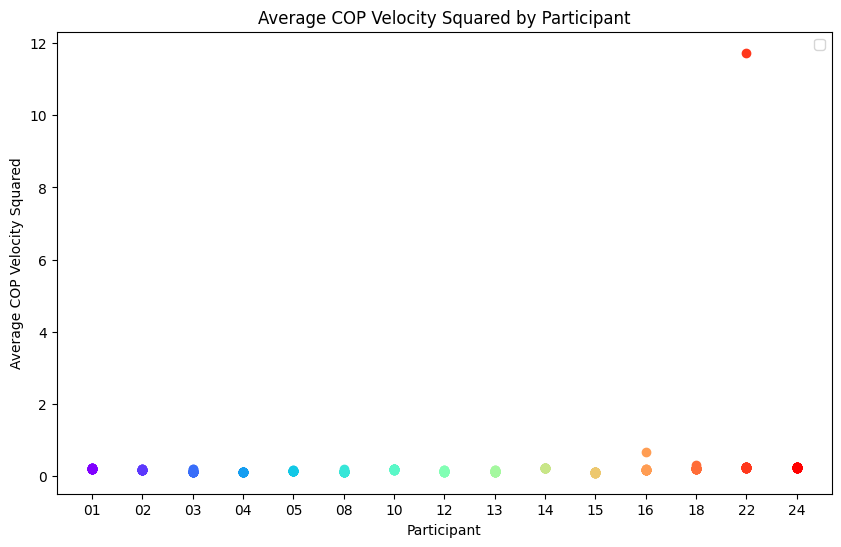

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import mplcursors

# Assuming FPDataCapture and event_labels_df are predefined and available

# Dictionary to collect results, keyed by participant with a list of radii as values
participant_results = {}

for index, row in event_labels_df.iterrows():
    participant = row['RADAR_capture'][:2]
    MOCAP_FP_capture_name = row['RADAR_capture'].replace('_RR_', '_MC_')
    base_file_path = f"/Volumes/FourTBLaCie/Yoga_Study_FP_1and2_MNTR/{participant}/{MOCAP_FP_capture_name}.tsv"
    force_plate_capture = FPDataCapture(base_file_path=base_file_path, is_foot_always_up=True)
    
    t_stable = row['t_stable']
    t_end = row['t_foot_down'] if np.isnan(row['t_break']) else row['t_break']
    
    # if MOCAP_FP_capture_name == '22_MNTRL_MC_V1' and  row['tx'] == "3":
    #     continue
    
    filtered_data = force_plate_capture.isolate_rows_by_time(t_stable, t_end)
    
    # Ensure velocity is defined outside the if-else block to avoid reference errors
    velocity = None  # Default value in case of insufficient data points

    # Check if there are at least 3 unique points    
    if len(filtered_data.drop_duplicates(subset=['COP_X', 'COP_Y'])) >= 3:
        velocity = force_plate_capture.average_velocity_squared(filtered_data)
        print(f"velocity for {MOCAP_FP_capture_name}, tx {row['tx']} is: {velocity}")
        # Store the results or continue with your logic
    else:
        print(f"Not enough points to calculate velocity for {MOCAP_FP_capture_name}, tx {row['tx']}")
        # Handle cases with insufficient points here
        
        # Only store the results if velocity was calculated
    

    
    if velocity is not None:
        if participant not in participant_results:
            participant_results[participant] = []
        # Append the tuple (velocity, MOCAP_FP_capture_name, tx) to the list for this participant
        participant_results[participant].append((velocity, MOCAP_FP_capture_name, row['tx']))

# Use a unique color for each participant
colors = plt.cm.rainbow(np.linspace(0, 1, len(participant_results)))

plt.figure(figsize=(10, 6))
for (participant, results), color in zip(participant_results.items(), colors):
    for result in results:
        velocity, capture_name, tx = result
        scatter = plt.scatter(participant, velocity, color=color)
        scatter.set_pickradius(5)
        # Tag each point with its capture name and tx for later identification
        scatter.set_gid(f"{capture_name}, tx {tx}")

# Adding interactivity with mplcursors
cursor = mplcursors.cursor(hover=True)
@cursor.connect("add")
def on_add(sel):
    # Retrieve the tagged information
    sel.annotation.set_text(sel.artist.get_gid())

plt.title('Average COP Velocity Squared by Participant')
plt.xlabel('Participant')
plt.ylabel('Average COP Velocity Squared')
plt.legend()
plt.show()

# # Assuming you want to plot each participant's enclosing circle velocity with a different color
# colors = plt.cm.rainbow(np.linspace(0, 1, len(participant_results)))

# plt.figure(figsize=(10, 6))
# for (participant, radii), color in zip(participant_results.items(), colors):
#     plt.scatter([participant] * len(radii), radii, color=color, label=f'Participant {participant}')

# plt.title('Enclosing Circle velocity by Participant')
# plt.xlabel('Participant')
# plt.ylabel('Enclosing Circle velocity')
# plt.legend()
# plt.show()


dist to centroid

max_dist_from_centroid for 01_MNTRL_MC_V1, tx 1 is: 22.656851806555256
max_dist_from_centroid for 01_MNTRL_MC_V1, tx 2 is: 21.584920803502374
max_dist_from_centroid for 01_MNTRL_MC_V1, tx 3 is: 13.99464794169093
max_dist_from_centroid for 01_MNTRL_MC_V2, tx 1 is: 18.429923645776682
max_dist_from_centroid for 01_MNTRL_MC_V2, tx 2 is: 16.39141576912126
max_dist_from_centroid for 01_MNTRL_MC_V2, tx 3 is: 21.57986117216015
max_dist_from_centroid for 01_MNTRL_MC_V3, tx 1 is: 27.020445190493717
max_dist_from_centroid for 01_MNTRL_MC_V3, tx 2 is: 20.937297833667316
max_dist_from_centroid for 01_MNTRL_MC_V3, tx 3 is: 17.994155533109417
max_dist_from_centroid for 01_MNTRR_MC_V1, tx 1 is: 18.86317198241268
max_dist_from_centroid for 01_MNTRR_MC_V1, tx 2 is: 10.33399627496638
max_dist_from_centroid for 01_MNTRR_MC_V1, tx 3 is: 14.106686431554003
max_dist_from_centroid for 01_MNTRR_MC_V2, tx 1 is: 10.572482856134657
max_dist_from_centroid for 01_MNTRR_MC_V2, tx 2 is: 20.277771675032533
max_dist_fr

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


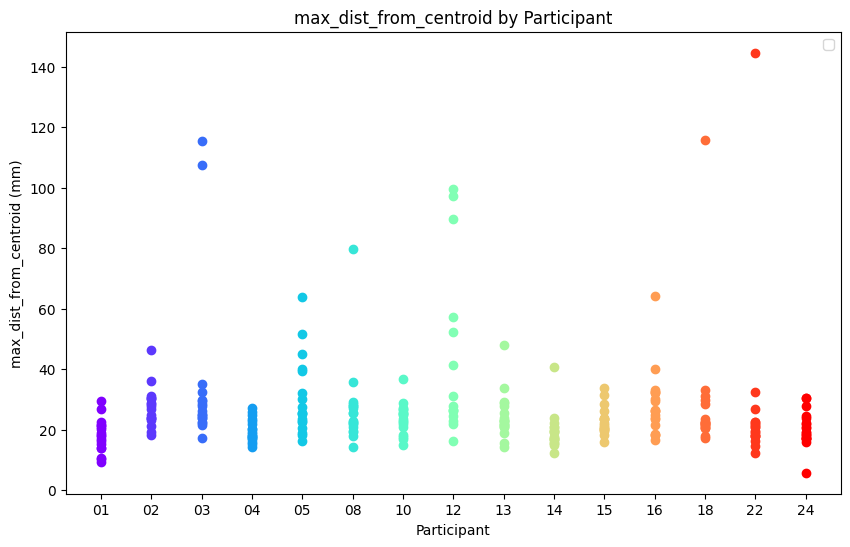

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import mplcursors

# Assuming FPDataCapture and event_labels_df are predefined and available

# Dictionary to collect results, keyed by participant with a list of radii as values
participant_results = {}

for index, row in event_labels_df.iterrows():
    participant = row['RADAR_capture'][:2]
    MOCAP_FP_capture_name = row['RADAR_capture'].replace('_RR_', '_MC_')
    base_file_path = f"/Volumes/FourTBLaCie/Yoga_Study_FP_1and2_MNTR/{participant}/{MOCAP_FP_capture_name}.tsv"
    force_plate_capture = FPDataCapture(base_file_path=base_file_path, is_foot_always_up=True)
    
    t_stable = row['t_stable']
    t_end = row['t_foot_down'] if np.isnan(row['t_break']) else row['t_break']
    
    filtered_data = force_plate_capture.isolate_rows_by_time(t_stable, t_end)
    
    # Ensure max_dist_from_centroid is defined outside the if-else block to avoid reference errors
    max_dist_from_centroid = None  # Default value in case of insufficient data points

    # Check if there are at least 3 unique points    
    if len(filtered_data.drop_duplicates(subset=['COP_X', 'COP_Y'])) >= 3:
        max_dist_from_centroid = force_plate_capture.maximum_distance_from_centroid(filtered_data)
        print(f"max_dist_from_centroid for {MOCAP_FP_capture_name}, tx {row['tx']} is: {max_dist_from_centroid}")
        # Store the results or continue with your logic
    else:
        print(f"Not enough points to calculate max_dist_from_centroid for {MOCAP_FP_capture_name}, tx {row['tx']}")
        # Handle cases with insufficient points here
        
        # Only store the results if max_dist_from_centroid was calculated
            
    if max_dist_from_centroid is not None:
        if participant not in participant_results:
            participant_results[participant] = []
        # Append the tuple (max_dist_from_centroid, MOCAP_FP_capture_name, tx) to the list for this participant
        participant_results[participant].append((max_dist_from_centroid, MOCAP_FP_capture_name, row['tx']))

# Use a unique color for each participant
colors = plt.cm.rainbow(np.linspace(0, 1, len(participant_results)))

plt.figure(figsize=(10, 6))
for (participant, results), color in zip(participant_results.items(), colors):
    for result in results:
        max_dist_from_centroid, capture_name, tx = result
        scatter = plt.scatter(participant, max_dist_from_centroid, color=color)
        scatter.set_pickradius(5)
        # Tag each point with its capture name and tx for later identification
        scatter.set_gid(f"{capture_name}, tx {tx}")

# Adding interactivity with mplcursors
cursor = mplcursors.cursor(hover=True)
@cursor.connect("add")
def on_add(sel):
    # Retrieve the tagged information
    sel.annotation.set_text(sel.artist.get_gid())

plt.title('max_dist_from_centroid by Participant')
plt.xlabel('Participant')
plt.ylabel('max_dist_from_centroid (mm)')
plt.legend()
plt.show()

# # Assuming you want to plot each participant's enclosing circle max_dist_from_centroid with a different color
# colors = plt.cm.rainbow(np.linspace(0, 1, len(participant_results)))

# plt.figure(figsize=(10, 6))
# for (participant, radii), color in zip(participant_results.items(), colors):
#     plt.scatter([participant] * len(radii), radii, color=color, label=f'Participant {participant}')

# plt.title('Enclosing Circle max_dist_from_centroid by Participant')
# plt.xlabel('Participant')
# plt.ylabel('Enclosing Circle max_dist_from_centroid')
# plt.legend()
# plt.show()


Vizualize differences in 04 and 10

Slice and generate labels

Split folders into Train, Validation, and Test

In [ ]:
import os
import random
from torch.utils.data import DataLoader
from StableRdmDataset import StableRdmDataset

root_dir = '/Volumes/FourTBLaCie/Yoga_Study_RADAR_Stable_1Ch'
event_csv = "/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/data/csvs/MOCAP_FP_RADAR_FU_Stable_Break_FD_TIME_FRAMES_v2.csv"

# Get all folders and shuffle them randomly
all_folders = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
random.seed(42)  # Replace 42 with any seed number you prefer
random.shuffle(all_folders)


# Calculate the number of folders for each set
num_train_folders = int(len(all_folders) * 0.7)
num_val_folders = int(len(all_folders) * 0.15)
num_test_folders = len(all_folders) - (num_train_folders + num_val_folders)

# Split the folders into train, validation, and test sets
train_folders = all_folders[:num_train_folders]
val_folders = all_folders[num_train_folders:num_train_folders + num_val_folders]
test_folders = all_folders[num_train_folders + num_val_folders:]

print(f'Train folders: {train_folders}')
print(f'Val folders: {val_folders}')
print(f'Test folders: {test_folders}')

# Define the setup_loaders function
def setup_loaders(root_dir, event_csv, folders):
    datasets = {x: StableRdmDataset(root_dir, event_csv, folders[x]) for x in ['train', 'val', 'test']}
    loaders = {x: DataLoader(datasets[x], batch_size=2, shuffle=True if x == 'train' else False, collate_fn=StableRdmDataset.collate_fn) for x in datasets}
    return loaders

# Assign folders to each data split
folders = {
    'train': train_folders,
    'val': val_folders,
    'test': test_folders
}

# Create the DataLoaders
loaders = setup_loaders(root_dir, event_csv, folders)
train_loader, val_loader, test_loader = loaders['train'], loaders['val'], loaders['test']


In [24]:
# Let's iterate through the test_loader and print out some information
for i, (sequences, labels, lengths, metadata) in enumerate(test_loader):
    print(f"Batch {i+1}")
    print(f"Sequences shape: {sequences.shape}")
    print(f"Labels shape: {labels.shape}")
    print(f"Velocity Labels: {labels}")
    print(f"Lengths: {lengths}")
    print(f"Metadata sample: {metadata[0]}")  # Print metadata of the first item in the batch as a sample
    if i == 2:  # Just print the first 3 batches to check
        break

Batch 1
Sequences shape: torch.Size([2, 86, 23, 13])
Labels shape: torch.Size([2])
Velocity Labels: tensor([0.2242, 0.2242])
Lengths: tensor([86, 86])
Metadata sample: {'RADAR_capture': '18_MNTRL_RR_V1', 'tx': 1, 'channel': 1, 'n_frames': 86, 'seconds_per_frame': 0.03776, 'frame_range': (279, 365.0), 'time_range': (10.85, 14.1)}
Batch 2
Sequences shape: torch.Size([2, 86, 23, 13])
Labels shape: torch.Size([2])
Velocity Labels: tensor([0.2242, 0.2242])
Lengths: tensor([86, 86])
Metadata sample: {'RADAR_capture': '18_MNTRL_RR_V1', 'tx': 1, 'channel': 3, 'n_frames': 86, 'seconds_per_frame': 0.03776, 'frame_range': (279, 365.0), 'time_range': (10.85, 14.1)}
Batch 3
Sequences shape: torch.Size([2, 92, 23, 13])
Labels shape: torch.Size([2])
Velocity Labels: tensor([0.3134, 0.3134])
Lengths: tensor([92, 92])
Metadata sample: {'RADAR_capture': '18_MNTRL_RR_V1', 'tx': 2, 'channel': 1, 'n_frames': 92, 'seconds_per_frame': 0.03776, 'frame_range': (486, 578.0), 'time_range': (18.67, 22.12)}


Generate RDM DataSets based on theses instances

In [9]:
# root_dir = '/Volumes/FourTBLaCie/Yoga_Study_RADAR_1Ch'
# output_dir = "/Volumes/FourTBLaCie/Yoga_Study_RADAR_Stable_1Ch"

# # Iterate only over included folders
# for folder_name in all_folders:
#     folder_path = os.path.join(root_dir, folder_name)
    
#     save_folder_path = os.path.join(output_dir, folder_name)
#     print(save_folder_path)
#     os.makedirs(save_folder_path, exist_ok=True)    
#     for file in sorted(os.listdir(folder_path)):
#         if file.endswith('.npy'):
#             filepath = os.path.join(folder_path, file)
#             radar_capture = "_".join(file.split('_')[:-1])  # Extract radar capture name
            
#             for index, row in event_labels_df[event_labels_df['RADAR_capture'].str.contains(radar_capture)].iterrows():
#                 # Ensure radar_capture matches one of the entries in the actuator CSV
#                 rdm_data = np.load(filepath)
                
#                 if not row['is_final_tx']:
#                     frame_stable, frame_break = row['frame_stable'], int(row['frame_break'])
#                 else:
#                     frame_stable, frame_break = row['frame_stable'], row['frame_end']
                
#                 print(f"Capture {radar_capture}, tx {str(row['tx'])} has {len(rdm_data[frame_stable:frame_break])} RDM Frames.")
                
#                 file_path_with_tx_number = file.replace(".npy","_tx" + str(row['tx']) + ".npy")
#                 print(file_path_with_tx_number)
#                 rdm_save_path = os.path.join(save_folder_path, file_path_with_tx_number)
#                 print(rdm_save_path)
#                 # Create window, label them, and add metadata
#                 np.save(rdm_save_path, rdm_data[frame_stable:frame_break])
#                 print(f"Saved to {rdm_save_path}")

Visualize a sample of the RADAR Data

In [10]:
# import numpy as np
# import imageio

# # Replace this with the actual path to your uploaded .npy file
# data = np.load('/Volumes/FourTBLaCie/Yoga_Study_RADAR_Stable_1Ch/24/24_MNTRR_RR_V3_channel4_tx3.npy')

# # Normalize the data to span the full 0-255 range
# data_min = data.min()
# data_max = data.max()
# normalized_data = ((data - data_min) / (data_max - data_min) * 255).astype(np.uint8)

# frames, height, width = normalized_data.shape

# gif_path =  "/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/data/gifs/test_stable_radar_data2.gif"
# with imageio.get_writer(gif_path, mode='I') as writer:
#     for frame in range(frames):
#         writer.append_data(normalized_data[frame])

# gif_path


In [17]:
# Assuming your radar data is 3D with shape (time_steps, height, width)
# and you've preprocessed it to have a fixed size, e.g., 32x32 for the spatial dimensions
num_channels = 1  # For radar data, this might be 1 if it's grayscale
hidden_dim = 128
lstm_layers = 2
bidirectional = False

model = RdmCNNLSTMModel(num_channels, hidden_dim, lstm_layers, bidirectional)
print(model)


RdmCNNLSTMModel(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lstm): LSTM(480, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)


In [18]:
def train_validate_model(model, dataloaders, criterion, optimizer, num_epochs=25, device=torch.device("cpu")):
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            
            # Iterate over data.
            for inputs, velocities, _, _ in dataloaders[phase]:
                inputs = inputs.to(device)
                velocities = velocities.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, velocities)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                
            epoch_loss = running_loss / len(dataloaders[phase].dataset)

            print(f'{phase} Loss: {epoch_loss:.4f}')

        print()

    print('Training complete')

    return model

def test_model(model, dataloader, device=torch.device("cpu")):
    model.eval()  # Set model to evaluate mode
    running_loss = 0.0
    criterion = nn.MSELoss()  # Example criterion, adjust as necessary

    # No gradient updates
    with torch.no_grad():
        for inputs, velocities, _, _ in dataloader:
            inputs = inputs.to(device)
            velocities = velocities.to(device)

            # Forward
            outputs = model(inputs)
            loss = criterion(outputs, velocities)

            # Statistics
            running_loss += loss.item() * inputs.size(0)

    total_loss = running_loss / len(dataloader.dataset)
    print(f'Test Loss: {total_loss:.4f}')


In [28]:
# Example setup
# model = CNNLSTMModel(...)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

dataloaders = {'train': train_loader, 'val': val_loader}

# Train and validate
model = train_validate_model(model, dataloaders, criterion, optimizer, num_epochs=25, device=device)




Epoch 1/25
----------
train Loss: 0.0010
val Loss: 0.0090

Epoch 2/25
----------
train Loss: 0.0009
val Loss: 0.0094

Epoch 3/25
----------
train Loss: 0.0009
val Loss: 0.0089

Epoch 4/25
----------
train Loss: 0.0008
val Loss: 0.0088

Epoch 5/25
----------
train Loss: 0.0008
val Loss: 0.0090

Epoch 6/25
----------
train Loss: 0.0008
val Loss: 0.0089

Epoch 7/25
----------
train Loss: 0.0007
val Loss: 0.0089

Epoch 8/25
----------


In [ ]:
# Test
test_model(model, test_loader, device=device)

Test Loss: 0.0047


Plot

In [26]:
model.eval()  # Set the model to evaluation mode
predictions = []
actuals = []

with torch.no_grad():  # Disable gradient calculation
    for inputs, labels, _, _ in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Generate predictions
        output = model(inputs)
        
        # Store predictions and actual values
        predictions.extend(output.view(-1).tolist())  # Flatten and convert to list
        actuals.extend(labels.view(-1).tolist())  # Flatten and convert to list


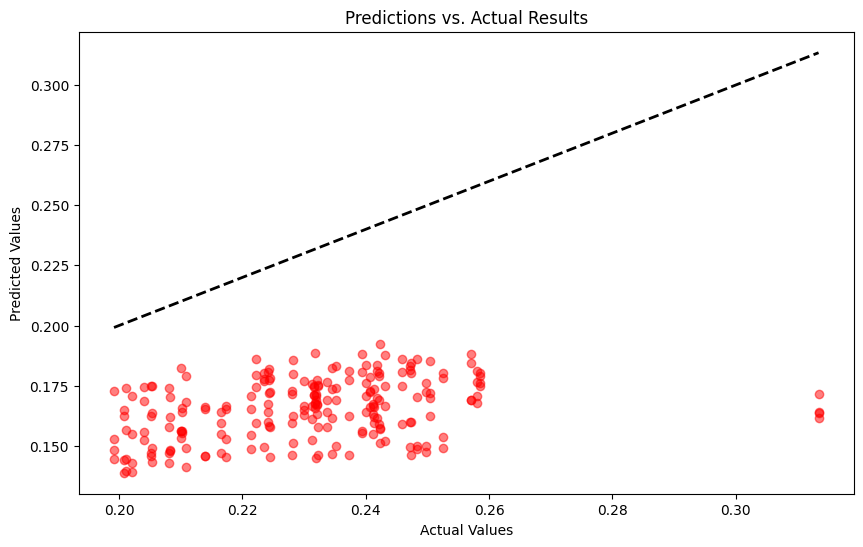

In [27]:
import matplotlib.pyplot as plt

# Convert lists to arrays for easier manipulation and plotting
predictions = np.array(predictions)
actuals = np.array(actuals)

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(actuals, predictions, alpha=0.5, color='red')  # Scatter plot of actual vs predictions
plt.plot([actuals.min(), actuals.max()], [actuals.min(), actuals.max()], 'k--', lw=2)  # A diagonal line for reference
plt.title('Predictions vs. Actual Results')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()
